# Modelo XGBboost

## Cargar y Preprocesar el Dataset

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import dask.dataframe as dd



# Cargar el dataset usando Dask para manejo eficiente de datos grandes
ddf = dd.read_csv('fraud_detection_dataset.csv')

# Optimizar tipos de datos
ddf['step'] = ddf['step'].astype('int32')
ddf['amount'] = ddf['amount'].astype('float32')
ddf['oldbalanceOrg'] = ddf['oldbalanceOrg'].astype('float32')
ddf['newbalanceOrig'] = ddf['newbalanceOrig'].astype('float32')
ddf['oldbalanceDest'] = ddf['oldbalanceDest'].astype('float32')
ddf['newbalanceDest'] = ddf['newbalanceDest'].astype('float32')
ddf['isFraud'] = ddf['isFraud'].astype('int8')
if 'IsFlaggedFraud' in ddf.columns:
    ddf['isFlaggedFraud'] = ddf['isFlaggedFraud'].astype('int8')

# Convertir Dask DataFrame a pandas DataFrame para muestreo inicial
sample_df = ddf.sample(frac=0.1, random_state=42).compute()

# Separar características y la variable objetivo
if 'isFlaggedFraud' in sample_df.columns:
    X = sample_df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
else:
    X = sample_df.drop(['isFraud'], axis=1)
y = sample_df['isFraud']

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocesar columnas categóricas
column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']),
        ('cat', OneHotEncoder(), ['type'])
    ],
    remainder='drop'
)

# Preprocesar los datos
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)


## Entrenamiento del Modelo con GPU

In [4]:
# Crear el DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros de XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.1,
    'eval_metric': 'auc',
    'tree_method': 'hist'  # Usa 'hist' para un mejor rendimiento en CPU
}

# Entrenar el modelo
bst = xgb.train(params, dtrain, num_boost_round=100)

# Hacer predicciones
y_pred_prob = bst.predict(dtest)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

# Evaluación del modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.9995861252416453
Confusion Matrix:
[[190635      5]
 [    74    165]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190640
           1       0.97      0.69      0.81       239

    accuracy                           1.00    190879
   macro avg       0.99      0.85      0.90    190879
weighted avg       1.00      1.00      1.00    190879



## Ajuste de Hiperparámetros

In [5]:
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a ajustar
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Crear el modelo base de XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='hist')

# Implementar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mejor modelo y sus parámetros
print(f'Mejor Score: {grid_search.best_score_}')
print(f'Mejores Hiperparámetros: {grid_search.best_params_}')

# Reentrenar con los mejores parámetros
best_params = grid_search.best_params_
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', tree_method='hist')
final_model.fit(X_train, y_train)

# Predicciones y evaluación final
final_y_pred_prob = final_model.predict_proba(X_test)[:, 1]
final_y_pred = [1 if prob > 0.5 else 0 for prob in final_y_pred_prob]

print(f'Final Accuracy: {accuracy_score(y_test, final_y_pred)}')
print('Final Confusion Matrix:')
print(confusion_matrix(y_test, final_y_pred))
print('Final Classification Report:')
print(classification_report(y_test, final_y_pred))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejor Score: 0.9995276861763673
Mejores Hiperparámetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Final Accuracy: 0.9996647090565227
Final Confusion Matrix:
[[190634      6]
 [    58    181]]
Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190640
           1       0.97      0.76      0.85       239

    accuracy                           1.00    190879
   macro avg       0.98      0.88      0.92    190879
weighted avg       1.00      1.00      1.00    190879



## Interpretación del Modelo

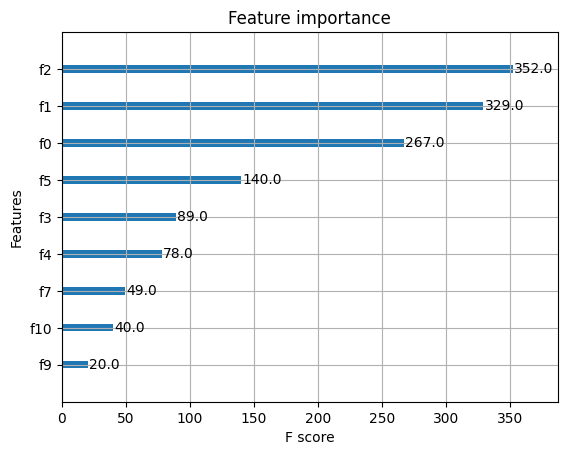

In [6]:
import matplotlib.pyplot as plt

# Importancia de características
xgb.plot_importance(final_model)
plt.show()
